In [1]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import cv2
import numpy as np
%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from robo_cheesecake.engine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext autoreload
%autoreload 2
from toolbox import object_detection_toolbox as odt
import os
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_depth_rgb_images_from_msg():
    msg = b.recv_msg("realsense_images", True)
    rgb = msg.get_rgb()
    dim_rgb = msg.get_shape_rgb()

    depth = msg.get_depth()
    dim_depth = msg.get_shape_depth()

    imrgb = np.reshape(rgb, dim_rgb)
    imdepth = np.reshape(depth, dim_depth)
    
    imdepth = cv2.resize(imdepth, dsize = (imrgb.shape[1], imrgb.shape[0]), interpolation = cv2.INTER_NEAREST)
    return (imrgb, imdepth)

[0.20780073 0.37495322 0.55747047 0.20780073]
[ 0.6801316   0.14607485  0.07193319  0.52870199  0.25408186 -0.11936578]
error: 0.2608762199970194
desired c pose: [ 0.6801316   0.14607485  0.07193319  0.52870199  0.25408186 -0.11936578]
c pose: [ 0.6801322   0.1460747   0.07193405  0.52865976  0.25407339 -3.14157938]


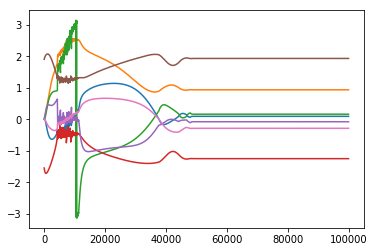

In [5]:
import SLRobot
from scipy.interpolate import interp1d
from scipy import interpolate

pgain_null = 0.002 * np.array([600.0, 600.0, 600.0, 600.0, 250.0, 150.0, 50.0], dtype=np.float64)

# Null-space theta configuration
target_th_null = np.zeros(7, dtype=np.float64)
target_th_null[3] = -1.55
target_th_null[5] = 1.9


def quatToEulerAngles(quat):

    eulerAngles = np.array([0.0]*3)
    threshold = 0.001
    qw = quat[0]
    qx = quat[1]
    qy = quat[2]
    qz = quat[3]  

    heading = np.arctan2(2.0*qy*qw-2.0*qx*qz , 1.0 - 2.0*qy*qy - 2.0*qz*qz)
    attitude = np.arcsin(2.0*qx*qy + 2.0*qz*qw)
    bank = np.arctan2(2.0*qx*qw-2.0*qy*qz , 1.0 - 2.0*qx*qx - 2.0*qz*qz)

    if (qx*qy + qz*qw - 0.5)*(qx*qy + qz*qw - 0.5) < threshold:
        heading = 2.0 * np.arctan2(qx,qw)
        bank = 0

    if (qx*qy + qz*qw + 0.5)*(qx*qy + qz*qw + 0.5) < threshold:
        heading = -2.0 * np.arctan2(qx,qw)
        bank = 0

    eulerAngles[0] = attitude
    eulerAngles[1] = heading
    eulerAngles[2] = bank

    return(eulerAngles)





def inverse_kin_6d(c_pos,q):

    J_reg = 1e-8

    # initialize the position
    J_w = np.diag([50, 50, 25, 10, 10, 5, 1])

    # compute the velocity in joint space and update the joint position
    qi = []
    EF_=[]
    qi.append(q)
    results_ =[]
    c_vel_all = []

    #while 1:
    plt.figure()

    for t in np.arange(100000):
        
        EF_FK = SLRobot.FK(np.array([q]))
        #print(EF_FK[0,50:56])
        c_vel = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.01])*(c_pos - EF_FK[0,50:56])

        #print(c_vel)
        J = SLRobot.Jacobian(np.array([q]), 6)
        target_th_null_out  = target_th_null
        
        A = J.dot(J_w).dot(J.transpose())
        A += J_reg * np.eye(6)

        qd_null = pgain_null * (target_th_null_out - q)
        qd_d = np.linalg.solve(A, c_vel - J.dot(qd_null))
        qd_d = J_w.dot(J.transpose()).dot(qd_d) + qd_null

        q = q + 0.002*qd_d

        #set the joint range
        mask_max = q > np.pi
        mask_min = q<-np.pi
        q[mask_max] = q[mask_max] - 2*np.pi
        q[mask_min] = q[mask_min] + 2*np.pi

        qi.append(q)
        EF_.append(EF_FK[0,50:56])
        c_vel_all.append(c_vel)

        # times the arrary to scale the orientation range.
        error_ = np.sqrt(np.sum(np.square(np.array([1.0, 1.0, 1.0, 0.08, 0.08, 0.08])*(c_pos-EF_FK[0,50:56]))))
        #print(error_)
        if error_ <0.0080:

            break
    
    print('error:', error_)

    qi = np.array(qi)
    # for debug    
    plt.plot(qi)

    EF_ = np.array(EF_)
    c_vel_all = np.array(c_vel_all)

    return qi[-1], EF_, qi, c_vel_all


# This is a grasping point recorded by Alexj and Felix
grasp_pt_quat = np.array([ 0.6801316 ,  0.14607485,  0.07193319,  0.37495322,  0.55747047, 0.20780073,  0.58338235])
grasp_pt_angles = quatToEulerAngles(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]])) #(np.array([0.37495322,  0.55747047, 0.20780073,  0.58338235]))
print(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]]))
grasp_pt = np.concatenate([grasp_pt_quat[:3], grasp_pt_angles])

q = target_th_null

#input_EF = np.array([0.6801316 ,  0.14607485,  0.07193319,  0.52870199,  0.25408186, -0.11936578])
input_EF = grasp_pt
print(input_EF)
j_ik = inverse_kin_6d(input_EF,q)
end_pos=j_ik[0]

EF_FK = SLRobot.FK(np.array([end_pos]))

print('desired c pose:', input_EF)
print('c pose:', EF_FK[0,50:56])

In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '../faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/dlrc1/Documents/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

with tf.device('/device:GPU:0'):
    detection_graph = tf.Graph()
    odt.load_model(PATH_TO_FROZEN_GRAPH, detection_graph)
    category_index = odt.create_category_index(PATH_TO_LABELS)
    with detection_graph.as_default() as graph:
        tensor_dict = odt.create_tensor_dict(['num_detections', 'detection_boxes', 'detection_scores',
        'detection_classes', 'detection_masks'])
    sess = tf.Session(graph=detection_graph)

In [6]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

Address broker could not acceppt the offered signal franka_target_pos. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_target_pos> successful


True

In [7]:
b.register_signal("franka_gripper", pab.MsgType.gripper_cmd)

Address broker could not acceppt the offered signal franka_gripper. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_gripper> successful


True

In [8]:
def GripApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Grasp)
    msg.set_width(0.065)
    msg.set_speed(0.8)
    msg.set_force(10)

    msg.set_epsilon_in(0.005)
    msg.set_epsilon_out(0.005)

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def ReleaseApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Move)
    msg.set_width(80)
    msg.set_speed(0.3)
 

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def GoHome(current_counter):
    Home=np.array([-0.3222667,  -0.39487693,  0.25124076, -1.78770602, -0.0087735,   1.58738244,   0.85377795])
    sleep_time = samples
    go_time = samples-0.1

    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Home, go_time=go_time)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    
    return current_counter
def TellMyGripper():
    return b.recv_msg('franka_state', -1).get_gripper_state()

In [9]:
b.request_signal("realsense_images", pab.MsgType.realsense_image)
b.request_signal("franka_state", pab.MsgType.franka_state, True)

current_counter=0

/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


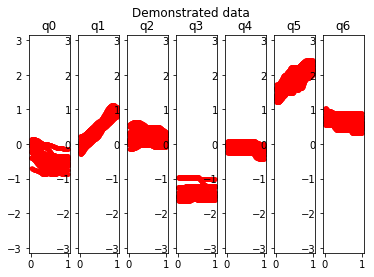

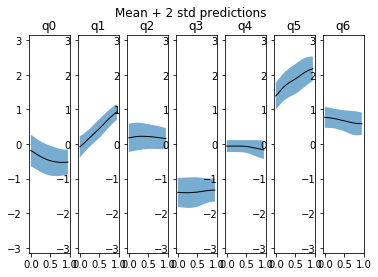

In [10]:
def PredZ(z):
    return RobotSaysHi.GeneratePrediction(w=RobotSaysHi.estimate_m, Z=z)[1]

df_generated, N=robotoolbox.PrepareData('JointsFinalPresentation_take2.p')

params = {'D' : 7, 'K' : 5, 'N' : N}
RobotSaysHi=ProMP(identifier='RobotSaysHi', TrainingData=df_generated, params=params)
RobotSaysHi.RegularizedLeastSquares() #Choice for l from [1]
RobotSaysHi.GenerateDemoPlot(xvariable="Phases")  
RobotSaysHi.MeanAndStdPredictionPlot(factor=2)
MaxTime=6
samples=1  



def FollowMeanTrajectory(ProMP, samples, MaxTime, current_counter):
    T, Q= ProMP.GetJointData(w=ProMP.estimate_m, robotrate=samples, MaxTime=MaxTime)
    robotoolbox.PlotTrajectory(T, Q)
    plt.show()
    time.sleep(4)
    
    sleep_time = samples
    go_time = samples-0.1
    for idxq, Q_pos in enumerate(Q):
        print(Q_pos)
        frame=current_counter+1
        target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Q_pos, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        time.sleep(sleep_time)
        if idxq==0:

            time.sleep(2)
        
    return current_counter




/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


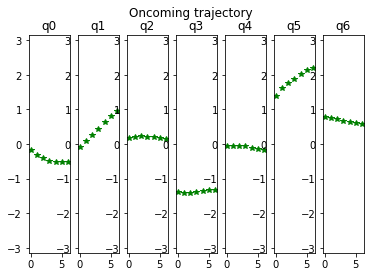

[-0.1849465  -0.07736842  0.18040424 -1.39581236 -0.05982821  1.39310514
  0.77282725]
[-0.30478945  0.09072378  0.21259689 -1.4042217  -0.05729575  1.60676766
  0.75140387]
[-0.40775832  0.26835872  0.2253219  -1.40203493 -0.05796996  1.76676191
  0.71643203]
[-0.47982367  0.44942837  0.21777614 -1.38644595 -0.0689347   1.88128965
  0.67112874]
[-0.51884101  0.64411056  0.20018375 -1.35889175 -0.10106932  2.01438031
  0.6249985 ]
[-0.52941924  0.82302151  0.17682245 -1.33618219 -0.13918346  2.12718265
  0.59537404]
[-0.5178315   0.96396539  0.15138092 -1.32557715 -0.17278856  2.19568246
  0.58758909]


In [11]:
current_counter=FollowMeanTrajectory(RobotSaysHi, samples, MaxTime,current_counter)

In [12]:
current_counter=GoHome(current_counter)
time.sleep(3)
current_counter=ReleaseApple(current_counter)

Point with respect to camera:  [ 0.11250873 -0.11124723  0.596       1.        ]
Point with respect to system F:  [ 0.158 -0.099  0.726  1.   ]
Point with respect to Base:  [ 0.727 -0.145  0.031  1.   ]
Location of the camera:  [0.534 0.044 0.586 1.   ]
Location of the coordinate Camerax:  [ 0.521 -0.055  0.594  1.   ]
Location of the coordinate Cameray:  [0.437 0.055 0.568 1.   ]
Location of the system F:  [ 0.434 -0.004  0.707  1.   ]
result: [[[ 0.727 -0.145  0.031]]]
[ 0.730635 -0.1537    0.081   ]


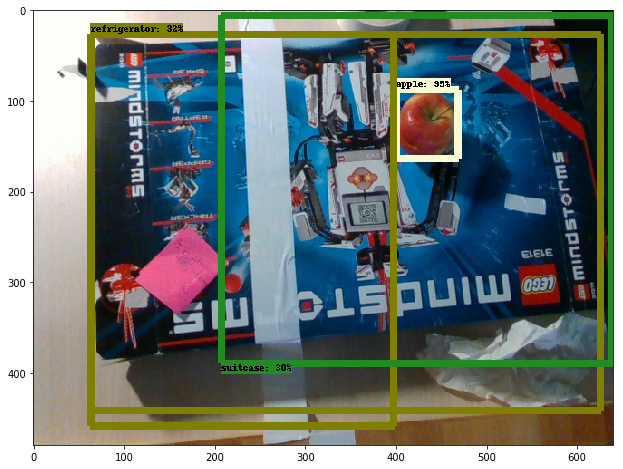

In [18]:
imrgb, imdepth = get_depth_rgb_images_from_msg()
start_time = time.time()
output_dict = odt.run_inference_for_single_image_test(imrgb, tensor_dict, sess)
#print('Iteration %d: %.3f sec'%(i, time.time()-start_time))
out = odt.visualize_pred_for_single_img(imrgb, output_dict, category_index)

Q = b.recv_msg('franka_state', -1).get_j_pos()
result, boxes = odt.get_boxes_with_label_and_threshold('apple', 0.5, output_dict, imdepth, Q, category_index)
print('result:', result)

target_pos = np.zeros(3)
#target_pos = np.array([0.6, 0.0, 0.1 ])
np.copyto(target_pos, result[0,0])
target_pos[0]  = target_pos[0]+0.005*target_pos[0]
target_pos[1] = target_pos[1]+0.06*target_pos[1]
target_pos[2] += 0.05

#target_pos[1] += 0.05 #offset
#target_pos[1] =- target_pos[1]
print(target_pos)



[ 0.730635 -0.1537    0.081   ]
[ 0.730635   -0.1537      0.081      -0.90519595  0.1040957  -3.11085005]
error: 0.007995129934793078
[-0.05713498  0.98937362 -0.2474743  -1.1679968   0.23521961  2.0476894
  0.58429495]
desired c pose: [ 0.730635   -0.1537      0.081      -0.90519595  0.1040957  -3.11085005]
c pose: [ 0.72708501 -0.16043528  0.07858592 -0.90517723  0.10406929 -3.11092504]


/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


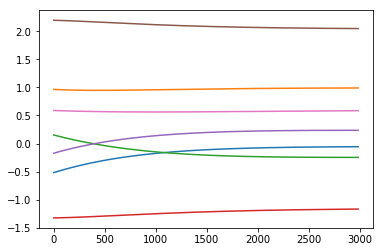

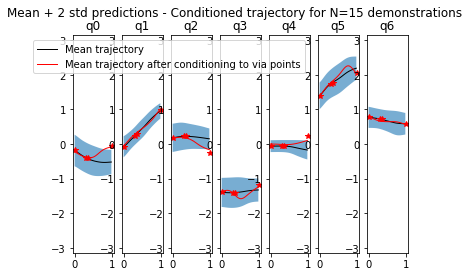

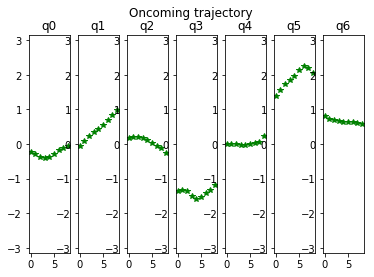

In [19]:
z=1
print(target_pos)

a=RobotSaysHi.GeneratePrediction(Z=1)[1]

bp= SLRobot.FK(a.reshape(1,-1))[0,50:56]
bp[0:3]=target_pos
#bp[0]=0.69
print(bp)
j_ik = inverse_kin_6d(bp,a)

end_pos=j_ik[0]

EF_FK = SLRobot.FK(np.array([end_pos]))
    
print(end_pos)

print('desired c pose:', bp)

print('c pose:', EF_FK[0,50:56])



Q_des=end_pos

#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m), Q_des], Ztarget=[0,z])        
w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m),PredZ(0.3) ,PredZ(0.35) , Q_des], Ztarget=[0,0.3,0.35,z])        

T, Q= RobotSaysHi.GetJointData(w=w_des, robotrate=samples, MaxTime=8)

Q[-1,:]=end_pos
robotoolbox.PlotTrajectory(T, Q)

#Qp,Qpp=robotoolbox.GetAccel(Q,T)
#robotoolbox.PlotAccel(T, Qpp)


In [20]:
def FollowTrajectory(Q)

sleep_time = samples
go_time = samples-0.1
for idxq, Q_pos in enumerate(Q):
    print(Q_pos)
    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Q_pos, go_time=go_time)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    if idxq==0:

        time.sleep(2)
        
        


#current_counter=GripApple(current_counter)
#time.sleep(0.5)
#if (TellMyGripper()>0.03):
#    print('I successfully gripped!')
#else: 
#    print('this did not go as expected....')

#current_counter=GoHome(current_counter)
#time.sleep(3)


#current_counter=ReleaseApple(current_counter)


#time.sleep(3)


[-0.22545279 -0.0465035   0.17063416 -1.36819001  0.00183231  1.39676923
  0.80356078]
[-2.98995195e-01  9.68853009e-02  1.90996979e-01 -1.33823803e+00
 -1.55155668e-03  1.56361146e+00  7.37030759e-01]
[-0.36324159  0.23673446  0.19708004 -1.36782699 -0.00678395  1.7217944
  0.68159553]
[-0.39390793  0.34921495  0.17327342 -1.4874491  -0.01314151  1.84531533
  0.65565776]
[-0.37576739  0.4485685   0.12271335 -1.57583238 -0.01272855  1.97423867
  0.64742128]
[-0.28753145  0.55490438  0.04013031 -1.53226589  0.00317776  2.14059973
  0.64815253]
[-0.18011498  0.68524157 -0.05047575 -1.42232488  0.03097334  2.25825871
  0.64212573]
[-0.11498617  0.85301619 -0.11712237 -1.31970462  0.06765344  2.19368307
  0.61147322]
[-0.05713498  0.98937362 -0.2474743  -1.1679968   0.23521961  2.0476894
  0.58429495]
I successfully gripped!


current_counter=0

def FollowAccelProfile(Qpp, current_counter, samples):
    
    rate_limit = 0.6  # Rate torque limit
    torque_limit = np.array([80, 80, 80, 80, 10, 10, 10], dtype=np.float64)  # Absolute torque limit


    
    for point in range(Qpp.shape[0]):
        
        target_j_acc=Qpp[point,:]
        msg_panda = b.recv_msg('franka_state', -1)

        mass = msg_panda.get_mass().reshape(msg_panda.get_mass_dim())
        uff = mass.dot(target_j_acc) + msg_panda.get_coriolis()
        if current_counter == 0:
            uff_last = uff    # Clip and rate limit torque
        uff_diff = uff - uff_last
        uff_diff = np.clip(uff_diff, -rate_limit, rate_limit)
        uff = uff_last + uff_diff
        uff = np.clip(uff, -torque_limit, torque_limit)    
        uff_last = uff
        last_c_vel = msg_panda.get_c_vel()    # Send out messages
        msg_out = pab.des_tau_msg()
        msg_out.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
        msg_out.set_fnumber(current_counter)
        msg_out.set_j_torque_des(-uff*30)
        print( uff)
        b.send_msg("franka_des_tau", msg_out)    
        current_counter += 1
        time.sleep(samples)
    return current_counter



current_counter=FollowAccelProfile(Qpp,current_counter,samples)
    

In [16]:
print(b.recv_msg('franka_state', -1).get_c_pos())

print(FrankaPanda.fk(end_pos))

[ 0.45300677 -0.01613909  0.5969544 ]
[ 0.743 -0.135  0.164]


In [17]:
print(b.recv_msg('franka_state', -1).get_j_pos())

print((end_pos))

[-0.31938347 -0.38554257  0.24860702 -1.79008007 -0.00289595  1.59126174
  0.82869101]
[-0.03287072  0.92160396 -0.24971528 -1.06588004  0.21162825  1.88186252
  0.63801659]


In [ ]:
current_counter=GripApple(current_counter)


In [ ]:
current_counter=ReleaseApple(current_counter)


In [ ]:
print(b.recv_msg('franka_state', -1).gripper_isGrasped())


In [ ]:
aaa = b.recv_msg('franka_state', -1)
aaa.get_gripper_state()

In [ ]:
aaa.get_gripper_state()

In [ ]:
aaa.ge

In [ ]:
class RoadMap:
    